# David Ogaus, Jonathan Caspar, Tommy Côté et Xiuli Zhang 
## IFT 3700
## 6 Novembre 2018
## Travail 1

## Mesure de similarité
ON va mettre ici notre description de la mesure de similarité

In [20]:
# La métrique euclidienne
def metric_euclid(x, y):
    sum=0
    for i in range(len(x)):
        sum += (x[i]-y[i])**2
    return math.sqrt(sum)

# La métrique #1 dans le fichier word
def metric_n1(x, y):
    sum_x=0
    sum_y=0
    for i in range(len(x)):
        sum_x += x[i]
        sum_y += y[i]
    return abs(sum_x - sum_y)

# La métrique #3 dans le fichier word
def metric_n3(x, y):
    sum=0
    for i in range(len(x)):
        if ((x[i]==0 and y[i]==0) or (x[i]!=0 and y[i]!=0)):
            sum+=1
    return 1 - sum/784

## Importation du jeu de données MNIST

In [21]:
import csv
import random
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import KernelPCA
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

#On ouvre le fichier 'mnist_train.csv'
data = open('e:\ift3700\mnist_train.csv')
csv_file = csv.reader(data)
data_points = []
for row in csv_file:
    data_points.append(row)
data.close()

#On enlève la première ligne, soit les "headers" de nos colonnes
data_points.pop(0)

#On transforme les données en integers
for i in range(len(data_points)):
    for j in range(0,785):
            data_points[i][j] = int(data_points[i][j])

#Vecteur 60 000 x 1 qui contient les étiquettes
y_train = []
for row in data_points:
    y_train.append(row[0])

#Matrice 60 000 x 784 qui contient les données
x_train = []
for row in data_points:
    x_train.append(row[1:785])
    
#On ouvre le fichier 'mnist_test.csv'
data = open('e:\ift3700\mnist_test.csv')
csv_file = csv.reader(data)
data_points = []
for row in csv_file:
    data_points.append(row)
data.close()

#On enlève la première ligne, soit les "headers" de nos colones
data_points.pop(0)

#Convertir en int
for i in range(len(data_points)):
    for j in range(0,785):
            data_points[i][j] = int(data_points[i][j])

#Vecteur 10 000 x 1 qui contient les étiquettes
y_test = []
for row in data_points:
    y_test.append(row[0])

#Matrice 10 000 x 784 qui contient les données
x_test = []
for row in data_points:
    x_test.append(row[1:785])


TypeError: list indices must be integers or slices, not tuple

## Algorithme k-moyenne

In [ ]:
def k_medoid(distances, k=10):

    m = distances.shape[0] # number of points

    # Pick k random medoids.
    curr_medoids = np.array([-1]*k)
    while not len(np.unique(curr_medoids)) == k:
        curr_medoids = np.array([random.randint(0, m - 1) for _ in range(k)])
    old_medoids = np.array([-1]*k) # Doesn't matter what we initialize these to.
    new_medoids = np.array([-1]*k)

    # Until the medoids stop updating, do the following:
    while not ((old_medoids == curr_medoids).all()):
        # Assign each point to cluster with closest medoid.
        clusters = assign_points_to_clusters(curr_medoids, distances)

        # Update cluster medoids to be lowest cost point.
        for curr_medoid in curr_medoids:
            cluster = np.where(clusters == curr_medoid)[0]
            new_medoids[curr_medoids == curr_medoid] = compute_new_medoid(cluster, distances)

        old_medoids[:] = curr_medoids[:]
        curr_medoids[:] = new_medoids[:]

    return clusters

def assign_points_to_clusters(medoids, distances):
    distances_to_medoids = distances[:,medoids]
    clusters = medoids[np.argmin(distances_to_medoids, axis=1)]
    assert (clusters[medoids] == medoids).all()
    return clusters
    
def compute_new_medoid(cluster, distances):
    mask = np.ones(distances.shape)
    mask[np.ix_(cluster,cluster)] = 0.
    cluster_distances = np.ma.masked_array(data=distances, mask=mask, fill_value=10e9)
    costs = cluster_distances.sum(axis=1)
    return costs.argmin(axis=0, fill_value=10e9)

Text(0.5,1,'Score silhouette en fonction de k')

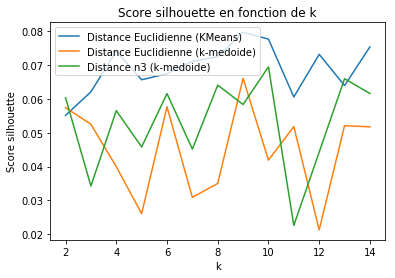

In [22]:
#Ensemble de donné réduit pour faire des tests
x__test= x_test[0:500]

# Définie une matrice des distances avec la métrique de notre choix
m_eucli = pairwise_distances(x__test, metric='euclidean')
m_n3 = pairwise_distances(x__test, metric=metric_n3)

scores = []
scores_t=[]
scores_n3=[]
k_range = range(2,15)
for k in k_range:
    y_pred = KMeans(n_clusters=k).fit_predict(x__test)
    scores.append(silhouette_score(x__test, y_pred))
    
    y_pred_t = k_medoid(m_eucli, k)
    scores_t.append(silhouette_score(x__test, y_pred_t))
    
    y_pred_n3 = k_medoid(m_n3, k)
    scores_n3.append(silhouette_score(x__test, y_pred_n3))

plt.plot(k_range, scores, label='Distance Euclidienne (KMeans)')
plt.plot(k_range, scores_t, label='Distance Euclidienne (k-medoide)')
plt.plot(k_range, scores_n3, label='Distance n3 (k-medoide)')
plt.legend(loc='upper left')
plt.xlabel('k')
plt.ylabel('Score silhouette')
plt.title('Score silhouette en fonction de k')

## Algorithme partition binaire

Text(0.5,1,'Score silhouette en fonction de k')

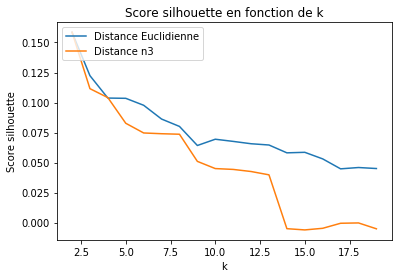

In [23]:
# Définie une matrice des distances avec la métrique de notre choix
m = pairwise_distances(x__test, metric=metric_n3)

scores = []
scores_t=[]
k_range = range(2,20)
for k in k_range:
    y_pred = AgglomerativeClustering(affinity='euclidean', linkage='average', n_clusters=k).fit_predict(x__test)
    scores.append(silhouette_score(x__test, y_pred))
    y_pred_t = AgglomerativeClustering(affinity='precomputed', linkage='average', n_clusters=k).fit_predict(m)
    scores_t.append(silhouette_score(x__test, y_pred_t))
plt.plot(k_range, scores, label='Distance Euclidienne')
plt.plot(k_range, scores_t, label='Distance n3')
plt.legend(loc='upper left')
plt.xlabel('k')
plt.ylabel('Score silhouette')
plt.title('Score silhouette en fonction de k')

## Algorithme PCoA

In [ ]:
from sklearn.manifold import MDS
x__test= x_test[0:50]
m = pairwise_distances(x__test, metric=metric_n3)
#m = pairwise_distances(x__test, metric=metric_n1)
#m = pairwise_distances(x__test, metric=metric_euclid)


y_pred =MDS(n_components=1,n_init=2).fit_transform(x__test)


y_pred_t =MDS(n_components=1,n_init=2).fit_transform(m)

plt.plot(y_pred, label='Distance Euclidienne')
plt.plot(y_pred_t, label='Distance n3')
plt.legend(loc='upper left')
plt.xlabel('Donnée de Test')


## Algorithme Isomap avec notre propre notation de similatrité

<function matplotlib.pyplot.show(*args, **kw)>

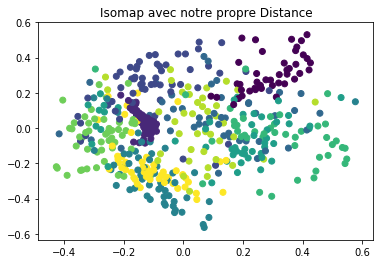

In [44]:
from sklearn.neighbors import NearestNeighbors, kneighbors_graph,KNeighborsClassifier
from sklearn.manifold import MDS
from sklearn.utils.graph import graph_shortest_path
from matplotlib.pyplot import scatter

kng = kneighbors_graph(x__test,n_neighbors=5, mode='distance',metric=metric_n3)
    #caculer le plus court chemin
distmatrix = graph_shortest_path(kng,directed=False,method ='D')
isomap=MDS(n_components=2,dissimilarity='precomputed')
X_transformed = isomap.fit_transform(distmatrix)#isomap avec notre distance propre
 
y=y_test[0:500]
fig1 = plt.figure()  
ax2 = fig1.add_subplot(111) 
ax2.set_title('Isomap avec notre propre Distance')
ax2.scatter(X_transformed[:,0],X_transformed[:,1] , c=y, alpha=1)
plt.show


## Algorithme Isomap avec Distance Euclidienne

<function matplotlib.pyplot.show(*args, **kw)>

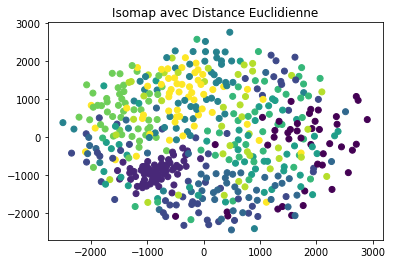

In [43]:
mds=MDS(n_components=2)
X_transformedEuc=mds.fit_transform(x__test)

y=y_test[0:500]
fig = plt.figure()  
ax1 = fig.add_subplot(111) 
ax1.set_title('Isomap avec Distance Euclidienne')
ax1.scatter(X_transformedEuc[:,0],X_transformedEuc[:,1] , c=y, alpha=1)
plt.show

In [ ]:
from sklearn.neighbors import NearestNeighbors, kneighbors_graph,KNeighborsClassifier
from sklearn.manifold import MDS
from sklearn.utils.graph import graph_shortest_path
from matplotlib.pyplot import scatter
#scores = []
#scores_t=[]
#k_range = range(2,20)

#for k in k_ra
nge:
    #caculer k voisin graphe
kng = kneighbors_graph(x__test,n_neighbors=5, mode='distance',metric=metric_n3)
    #caculer le plus court chemin
distmatrix = graph_shortest_path(kng,directed=False,method ='D')
    '''
    isomap=MDS(n_components=500,dissimilarity='precomputed')
    X_transformed = isomap.fit_transform(distmatrix)#isomap avec notre distance propre
   
    #isomp avec euclidean
    mds=MDS(n_components=500)
    X_transformedEuc=mds.fit_transform(x__test)
    
    
    y_pred = KMeans(n_clusters=5).fit_predict( X_transformed )
    scores.append(silhouette_score(x__test, y_pred))
    
    y_pred_t = KMeans(n_clusters=5).fit_predict(X_transformedEuc )
    scores_t.append(silhouette_score(x__test, y_pred_t))
    

#visualiser silhouette score
plt.plot(k_range, scores, label='Distance propre (isomap)')
plt.plot(k_range, scores_t, label='Distance Euclidienne (isomap')

plt.legend(loc='upper left')
plt.xlabel('k')
plt.ylabel('Score silhouette')
plt.title('Score silhouette en fonction de k')
'''
#visualisation en 2D
isomap=MDS(n_components=2,dissimilarity='precomputed')
X_transformed = isomap.fit_transform(distmatrix)#isomap avec notre distance propre
X_transformed.shape
'''
mds=MDS(n_components=2)
X_transformedEuc=mds.fit_transform(x__test)
'''
y=y_test[:500]
plt.scatter(X_transformed[:,0],X_transformed[:,1] , c=y, alpha=0.5)
plt.show

#plt.scatter(X_transformedEuc[:,0],X_transformedEuc[:,1] , c=y, alpha=0.5)
#plt.show


## Algorithme KNN

[[1]
 [2]]
